### TASK 3

Use the DCGAN (or an improvement to it) to build a generator for a face image set of your choice. Can you get realistic faces that are not in the training set?

Dataset is taken from https://www.kaggle.com/drgilermo/face-images-with-marked-landmark-points

#### On FACE data,

##### The optimizers used are:

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))<br>

##### loss function:

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;loss = nn.BCELoss()<br>

##### the results after training for 50 epochs is as follows:

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Epoch: Epoch: [49/50], Batch Num: [0/71]<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Discriminator Loss: 0.3311, Generator Loss: 4.1701<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;D(x): 0.9438, D(G(z)): 0.2143

Here is a `Logger` class with a lot of useful tricks to indicate training progress and visualize results.

#### 3.1 Set up stuff

In [16]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [17]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
#     if torch.cuda.is_available(): return data.cuda()
    return data.to(device)

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
#     if torch.cuda.is_available(): return data.cuda()
    return data.to(device)

In [18]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

And here's a function for a single step of the generator:

In [19]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

#### Configure Device available

In [20]:
from chosen_gpu import get_freer_gpu

device = get_freer_gpu()

#### Generate test noise samples

Let's generate some noise vectors to use as inputs to the generator.
We'll use these samples repeatedly to see the evolution of the generator
over time.

In [21]:
# generate size vectors with 100 features
def noise(size):
    n = torch.randn(size, 100) # mean = 0, std = 1
    return n.to(device)
    
num_test_samples = 16
test_noise = noise(num_test_samples)

#### 3.2 DCGAN for FACE

In [22]:
# load the prepared dataset
from numpy import load
data = load('face/face_images.npz')
lst = data.files
for item in lst:
    print('item: ',item)
    print(data[item].shape)
    print(type(data[item]))
    data = data[item].reshape(-1,96,96)
    print(data.shape)

item:  face_images
(96, 96, 7049)
<class 'numpy.ndarray'>
(7049, 96, 96)


#### 3.3 Load CIFAR10 data

For our DCGAN experiment, we'll use FACE.

##### 3.3.1 Load image

In [23]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from PIL import Image

data = load('face/face_images.npz')
print(data[item].shape)
#print(data[item])

data = np.transpose(data[item],(2,0,1))
print(data[0].shape)
print(data.shape[0])

(96, 96, 7049)
(96, 96)
7049


##### 3.3.2 Convert to PIL image and load data on to the data loader

In [24]:
def create_PIL_img(data):
    for i in range(data.shape[0]):
        new_im = Image.fromarray(data[i].astype('uint8'),'L')
        new_im.save(f"face/faces/face{i}.png")

create_PIL_img(data)

In [25]:
from torchvision import transforms
import torchvision
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,], std=[0.5,]),
])

data = torchvision.datasets.ImageFolder('face/', transform = transform)
# Load Dataset and attach a DataLoader
batch_size = 100
data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
num_batches = len(data_loader)

In [26]:
print(num_batches)

71


#### 3.4 Network architechture

In [27]:
#NO BIASES BECAUSE BATCHNORM!!!
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False  
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

The generator is using transpose convolutions with batch normalization:

In [28]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)


Let's create a generator and discriminator and initialize their weights: 

In [29]:
# Custom weight initialization

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Instantiate networks

generator = GenerativeNet()
generator.apply(init_weights)
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available

if torch.cuda.is_available():
    generator.cuda(device)
    discriminator.cuda(device)

#### 3.5 Optimizers and loss function

Next, we set up the optimizers and loss function.

In [32]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# Number of epochs of training
num_epochs = 200

#### 3.6 Training

As before, we'll generate a fixed set of noise samples to see the evolution of the
generator over time then start training:

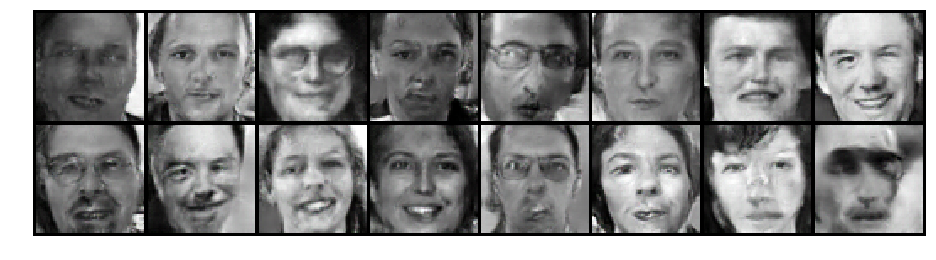

Epoch: [199/200], Batch Num: [0/71]
Discriminator Loss: 0.0430, Generator Loss: 5.5824
D(x): 0.9714, D(G(z)): 0.0126


In [33]:
num_test_samples = 16
test_noise = noise(num_test_samples)

logger = Logger(model_name='DCGAN', data_name='FACE')

for epoch in range(num_epochs):
    for n_batch, (real_data,_) in enumerate(data_loader):

        # Train Discriminator
        
        if torch.cuda.is_available(): real_data = real_data.cuda(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Train Generator
        
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        # Log error and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)


Populating the interactive namespace from numpy and matplotlib


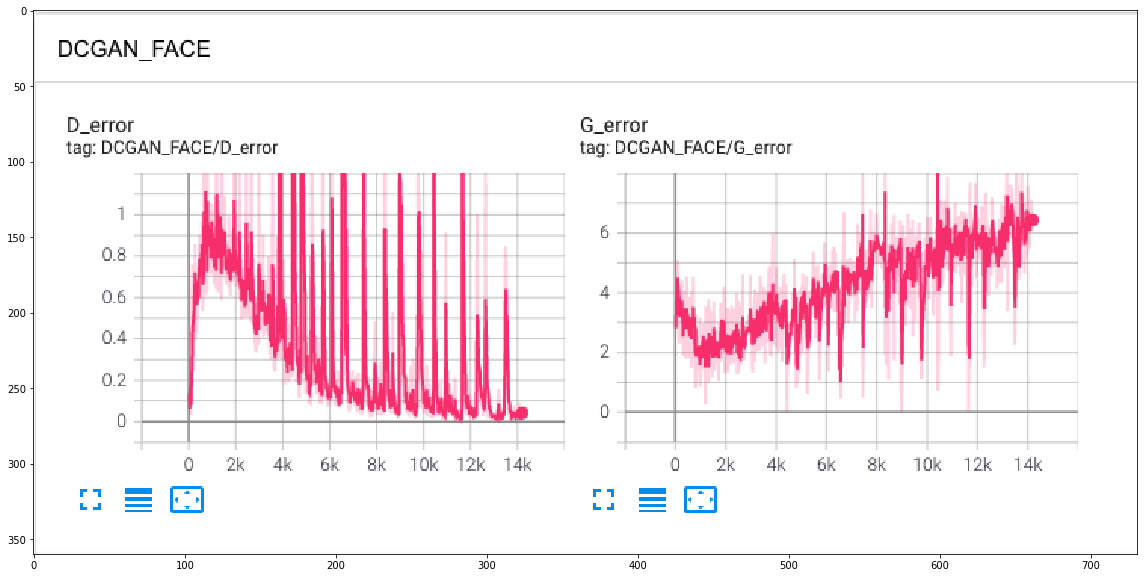

In [37]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('plots_tensorboard/face2.png')
plt.figure(figsize = (20,10))
imgplot = plt.imshow(img)
plt.show()


#### Evaluation on FACE

Traing GANs on SNAKE dataset does not produce as positive results as others. That maybe due to not enough number of epochs. The number of epochs in this training is 50 which results in D(x) to be at 0.9438 which is still far off the optimal value which is 0.5. 

One important thing i learnt is how to use '.npz' file and how to convert it to PIL image in order to use the image folder before loading the data into the loader.